In [509]:
import warnings
warnings.filterwarnings('ignore')

import json

import pandas as pd
import numpy as np

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from selenium import webdriver
from bs4 import BeautifulSoup

In [510]:
# Константы
corona_url = "https://www.worldometers.info/coronavirus"
democracy_url = "https://en.wikipedia.org/wiki/Democracy_Index"
gdp_url = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(PPP)_per_capita"

plots_dir = 'plots/'
data_file = 'data.csv'
keys = ['country', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths',
        'total_rec', 'active_cases', 'critical',
        'tot_cases_1mpop', 'deaths_1mpop', 'total_tests', 'tests_1mpop']

country_replacement = {
    'United States': 'USA',
    'United Kingdom': 'UK',
    'South Korea[n 2]': 'S. Korea',
    'United Arab Emirates': 'UAE',
    'Czech Republic': 'Czechia',
    'Democratic Republic of the Congo': 'DRC',
#     '': '',
}

#### Сбор данных

In [511]:
# Сбор данных по коронавирусу
def coronavirus_scrap(driver):

    # Получаем разметку страницы
    driver.get(corona_url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Извлекаем html-таблицу с нужными нам данными
    table = soup.find('table', attrs={
        'id': 'main_table_countries_today',
    })
    table = table.findChildren('tbody', recursive=False)[0]

    # Извлекаем данные
    raw_data = {key: [] for key in keys}
    for row in table.find_all('tr', style=lambda x: x != 'display: none', recursive=False):
        for i, col in enumerate(row.find_all('td', recursive=False)):

            # Пропускается название континента
            if i < len(keys):
                raw_data[keys[i]].append(col.text)

    # Создаем датафрейм с необработанными данными
    raw_df = pd.DataFrame(raw_data)
    return raw_df

In [512]:
# Сбор данных о политическом режиме
def democracy_index_scrap(driver):
    
    driver.get(democracy_url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    table = soup.find('table', attrs={
        'style': 'text-align:center;'
    })
    table = table.find_all('tbody', recursive=False)[0]
    all_rows = table.find_all('tr')[1:-1]
    country_demoindex = {}
    for row in all_rows:
        cols = row.find_all('td')
        
        # Обработка особых объединенных строк
        if '.' in cols[1].text.strip():
            country_demoindex[cols[0].text.strip()] = cols[1].text.strip()
        else:
            country_demoindex[cols[1].text.strip()] = cols[2].text.strip()
    
    return country_demoindex

In [513]:
# Сбор данных о ВВП
def gdp_scrap(driver):
    
    driver.get(gdp_url)
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    
    table = soup.find('table', attrs={
        'style': 'margin-left:auto;margin-right:auto;text-align: right'
    })
    table = table.find_all('tbody', recursive=False)[0]
    all_rows = table.find_all('tr')[1:-3]
    country_gdp = {}
    for row in all_rows:
        cols = row.find_all('td')
        country_gdp[cols[1].text.strip()] = cols[2].text.strip().replace(',', '')
    
    return country_gdp

#### Очистка данных

In [514]:
def data_cleaning(raw_df):
    # Удалим первую строку с общемировыми показателями
    raw_df = raw_df.iloc[1:, :]
    
    # Проведем очистку для каждого столбца
    for key in keys[1:]:
        raw_df[key] = raw_df[key].apply(lambda x: x.strip().replace(',', '').replace('+', ''))
        raw_df[key] = pd.to_numeric(raw_df[key], errors='ignore')
    return raw_df

#### Собираем воедино

In [515]:
# Запускаем браузер
driver = webdriver.Chrome()

In [516]:
# Собираем данные по коронавирусу
df = coronavirus_scrap(driver)

In [517]:
# Собираем данные о политическом режиме
demo_idx = democracy_index_scrap(driver)

# Приводим в общий вариант 
demo_idx = {country_replacement.get(key, key): value for key, value in demo_idx.items()}

df['demo_idx'] = df['country'].map(demo_idx)
df['demo_idx'] = df['demo_idx'].astype(np.float32)

In [518]:
# Собираем данные о ВВП
gdp = gdp_scrap(driver)

# Приводим в общий вариант 
gdp = {country_replacement.get(key, key): value for key, value in gdp.items()}

df['gdp'] = df['country'].map(gdp)
df['gdp'] = df['gdp'].astype(np.float32)

In [519]:
# Очищаем получнные данные
df = data_cleaning(df)

In [520]:
# Завершение работы браузера
driver.close()

# Сохранение датафрейма
df.to_csv(data_file)

df.head()

,country,total_cases,new_cases,total_deaths,new_deaths,total_rec,active_cases,critical,tot_cases_1mpop,deaths_1mpop,total_tests,tests_1mpop,demo_idx,gdp
1,USA,990021,2861.0,55499.0,86.0,118869,815653,15143.0,2991.0,168.0,5530655.0,16709.0,7.96,67426.0
2,Spain,229422,2793.0,23521.0,331.0,120832,85069,7764.0,4907.0,503.0,1345560.0,28779.0,8.29,43007.0
3,Italy,197675,NaN,26644.0,NaN,64928,106103,2009.0,3269.0,441.0,1757659.0,29071.0,7.52,41582.0
4,France,162100,NaN,22856.0,NaN,44903,94341,4682.0,2483.0,350.0,463662.0,7103.0,8.12,48640.0
5,Germany,158142,372.0,5985.0,9.0,114500,37657,2570.0,1887.0,71.0,2072669.0,24738.0,8.68,55306.0


#### Анализ данных

In [521]:
# Расчитаем отношение числа заражений к числу смертей
df['cases_deaths_rate'] = np.round(df['total_cases'] / df['total_deaths'], 1)

In [562]:
red = '#C5388D'
# blue = '#7B59BF'
blue = '#000000'
grey = '#F8F8F8'

In [563]:
# Отслеживая показатель 'by', построим топ-'n' стран по числу заболевших
def plot_topn_by(n, by, title, color_depends_on, highlight_russia=False,
                 show_labels=True, show_xticks=True, show=True, save=False):
    top_cases_df = df.iloc[:n, :]

    fig, ax = plt.subplots(figsize=(16, 12))
    ax.set_facecolor(grey)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['bottom'].set_edgecolor('#aaaaaa')

    # Создание сетки по оси x
    xs = range(len(top_cases_df))

    # Создание решетки
    plt.grid(axis='y', color='#dddddd')

    # Отрисовка столбчатой диаграммы
    if color_depends_on is not None:
        norm = colors.Normalize(df[color_depends_on].min(), df[color_depends_on].max())
        cmap = cm.get_cmap('magma')
        color = cmap(norm(top_cases_df[color_depends_on].values))
    else:
        color = blue
        
    rects = ax.bar(xs, top_cases_df[by], 
                   width=0.7, 
                   color=color)

    # Метки значений каждого столбца
    if show_labels:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(height, 
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=10)
    
    # Выделяем Россию
    if highlight_russia:
        russia_index = top_cases_df.index[top_cases_df['country'] == 'Russia'][0] - 1
        max_rate = top_cases_df[by].max()
        ax.scatter([xs[russia_index]],
                   rects[russia_index].get_height() + max_rate * 0.04, 
                   color=red,
                   s=85,
                   marker='v')

    ax.set_title(f"{title} (top-{n} по случаям заболевания)", fontsize=14)
    ax.set_axisbelow(True)
    
    if show_xticks:
        plt.xticks(xs, top_cases_df['country'], rotation='vertical', fontsize=11)
    
    if save:
        plt.savefig(plots_dir + f'top{n}_by-{by}.png', dpi=280)
        
    if show:
        plt.show()
    else:
        plt.close()

In [565]:
ns = [10, 20, 30, 50, 70]
for n in ns:
    if n > 70:
        show_ticks = False
    else:
        show_ticks = True
    plot_topn_by(n=n, by='cases_deaths_rate', color_depends_on='demo_idx',
                 title="Отношение числа зараженных к числу заболевших", 
                 show_labels=False, show_xticks=show_ticks, 
                 highlight_russia=True, show=False, save=True)
    
    plot_topn_by(n=n, by='total_deaths', color_depends_on='demo_idx', title="Число смертей",
                 show_labels=False, show_xticks=show_ticks, 
                 highlight_russia=True, show=False, save=True)

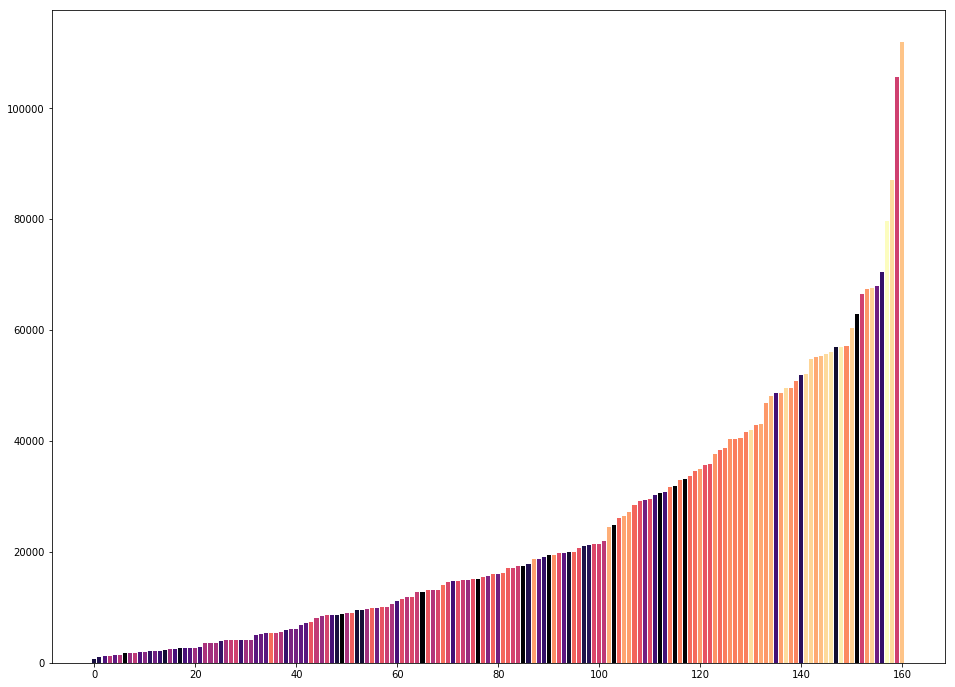

In [553]:
sorted_df = df.sort_values(by='gdp').iloc[:, -3:]

norm = colors.Normalize(sorted_df['demo_idx'].min(), sorted_df['demo_idx'].max())
cmap = cm.get_cmap('magma')
color = cmap(norm(sorted_df['demo_idx'].values))

plt.figure(figsize=(16, 12))
xs = range(len(sorted_df))
plt.bar(xs, sorted_df['gdp'], color=color)
plt.show()